# Plot for comparing spread

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib.resources import path
from re import I
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

import sys
sys.path.append("..")
from utils.model3 import Net_mask
from utils.data import Data
from utils.loss_experiment import Loss
from utils.lr_scheduler import lr_scheduler
from utils.weights import set_weights
from scripts.parameters import get_parameters
#
import os
import shutil

from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
import sys
sys.path.append("..")
import os
from utils.model3 import Net_mask
from utils.data import Data
from utils.loss_experiment import Loss
from scripts.parameters import get_parameters
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
tensor_D = torch.tensor(
    [[1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,  1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0,  0, 1, -1, 0, 0, 0, 0, 0],
    [0, 0,  0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0,  0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0,  0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0,  0, 0, 0, 0, 0, 1, -1, 0],
    [0, 0,  0, 0, 0, 0, 0, 0, 1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, 1],], dtype=torch.float
)
tensor_Q_m  = torch.mm(torch.t(tensor_D), tensor_D)
n_param = tensor_D.size(dim=0)
tau2 = 1000 # 1/tau2 is the noise added to the diagonal
tensor_Q_m_modified = tensor_Q_m + torch.eye(n_param)*(1./tau2)
sigma2_eps = 0.01  # 1/sigma2_eps is the factor before the likelihood
tensor_mu_m = torch.zeros(n_param)

tensor_Sigma_m = torch.inverse(tensor_Q_m_modified)
tensor_Sigma_eps = torch.eye(n_param)*sigma2_eps
tensor_mu_eps = tensor_mu_m 

data = Data(tensor_mu_m, tensor_Sigma_m, tensor_mu_eps, tensor_Sigma_eps)


number_of_data = 10000
lambda_ = 0.5
lambda2 = lambda_**2
l2_lambda =  1./(number_of_data*lambda2) 

In [14]:
loss = Loss(tensor_Q_m_modified, sigma2_eps, l2_lambda)
model = Net_mask() 
name = '../saved_models/bnn_100/map/0/model_weights.pth'
model.load_state_dict(torch.load(name))
model.eval()

Net_mask(
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [37]:
model2 = Net_mask() 
name2 = '../saved_models/bnn_100/pos/0/model_weights.pth'
model2.load_state_dict(torch.load(name))
model2.eval()

Net_mask(
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [38]:
data_obses = torch.load('../data/1000/data_n_1000_var_1.pt')

In [22]:
obs1 = data_obses[1,:].unsqueeze(0)
#model(obs1)
tensor_output = model(obs1)
tensor_losses_sum, tensor_losses_likelihood, tensor_losses_prior, tensor_losses_regularization = loss.loss(obs1, tensor_output, model)
print(tensor_losses_sum)

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [24]:
post

tensor([-8.5908e-01,  7.5016e-01,  1.7934e+00,  1.9997e-01, -1.3934e+00,
        -1.1557e+00, -1.0100e-01, -6.7405e-02, -3.3920e-02, -4.3335e-04])

In [39]:
n = 1000
x_analytical = torch.zeros(1000)
y_map = torch.zeros(1000)
y_bnn = torch.zeros(1000)
for i in range(n):
    obs = data_obses[i,:]
    post, _ = data.get_tensor_posterior(obs)
    post = post.unsqueeze(0)
    obs = obs.unsqueeze(0)
    tensor_output = model(obs)
    tensor_output2 = model(obs)
    loss_analytical, _, _, _ = loss.loss(obs, post, model)
    loss_map, _, _, _ = loss.loss(obs, tensor_output, model)
    loss_bnn, _, _, _ = loss.loss(obs, tensor_output2, model)
    x_analytical[i] = loss_analytical
    y_map[i] = loss_map
    y_bnn[i] = loss_bnn

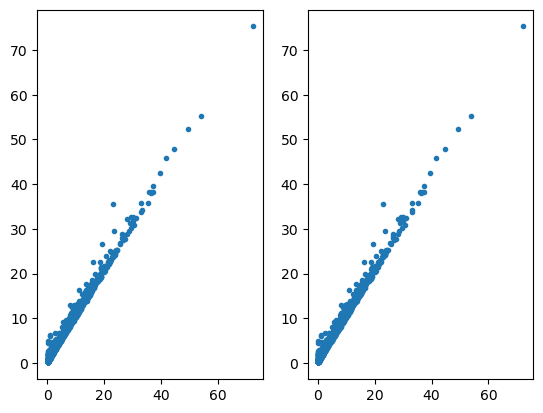

In [41]:
plt.subplot(1,2,1)
plt.plot(x_analytical.detach().numpy(), y_map.detach().numpy(), '.')
plt.subplot(1,2,2)
plt.plot(x_analytical.detach().numpy(), y_bnn.detach().numpy(), '.')

In [6]:
def plot_comp_spread(num):
    tensor_raw = torch.load('../data/test_observations/all_test_observations.pt')[num,:].unsqueeze(0)
    n_param = 10
    input_tensor = tensor_raw[0]
    mask = input_tensor[10:]
    location_raw = torch.where(mask > 0.5)
    location = location_raw[0]
    points = tensor_raw[0][location_raw]
    post_mean, _ = data_generator.get_tensor_posterior(input_tensor)

    # Plotting model estimates
    model = Net_mask()

    names = []
    sum_tensor_map = torch.zeros(n_param)

    n_runs = 100
    plt.plot(range(10), post_mean, 'b')
    sum_tensor_bnn = torch.zeros(n_param)
    plt.subplot(1,2,1)
    for f in range(n_runs): 
        name = '../saved_models/bnn_100/pos/' + str(f) + '/' + 'model_weights.pth'
        model.load_state_dict(torch.load(name))
        model.eval()
        out_raw = model(tensor_raw)
        out = out_raw[0].detach()
        sum_tensor_bnn += out
        plt.plot(range(10), out, alpha=1)#, 'o')
    #plt.plot(range(10), sum_tensor_bnn/10, 'r')

    plt.title('10e^5 observations')
    plt.plot(range(10), post_mean, 'b')
    plt.plot(location, points, 'bo')
    plt.xlabel("m")
    plt.ylabel("m|d")
    plt.legend(['Analytical'])#, 'Bagged BNN', 'MAP'])
    plt.axis([-0.5, 9.5, -2, 2])


    plt.subplot(1,2,2)
    for f in range(n_runs): 
        name = '../saved_models/bnn_n_10000_b_100/pos/' + str(f) + '/' + 'model_weights.pth'
        model.load_state_dict(torch.load(name))
        model.eval()
        out_raw = model(tensor_raw)
        out = out_raw[0].detach()
        sum_tensor_bnn += out
        plt.plot(range(10), out, alpha=1)#, 'o')

    plt.title('10e^4 observations')
    plt.plot(range(10), post_mean, 'b')
    plt.plot(location, points, 'bo')
    plt.xlabel("m")
    plt.ylabel("m|d")
    plt.legend(['Analytical'])#, 'Bagged BNN', 'MAP'])
    plt.axis([-0.5, 9.5, -2, 2])
    plt.savefig('../figures/fig.png')

In [7]:
plot_comp_spread(42)

NameError: name 'data_generator' is not defined